# Multivariate Time Series Prediction of Beijing Municipal Environmental Pollution.

## Purpose:
The objective of this project is to develop a model to perform time series prediction.

### Data Set Information:

This data set includes hourly air pollutants data from 12 nationally-controlled air-quality monitoring sites. The air-quality data are from the Beijing Municipal Environmental Monitoring Center. The meteorological data in each air-quality site are matched with the nearest weather station from the China Meteorological Administration. The time period is from March 1st, 2013 to February 28th, 2017, spanning a period of 4 years.

For this project, the focus is on the city of Wanshouxigong. 

Original source of the dataset:

http://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data
___
___

In [1]:
# Run this cell to mount google drive if using Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For time stamps
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D

from sklearn.metrics import mean_squared_error

## Read in the data set

In [3]:
# define path to csv file
file_path = "/content/drive/MyDrive/metro_traffic/air_pollution_forecast/Air_Pollution_Data_Wanshouxigong.csv"

# read the csv file
df = pd.read_csv(file_path)

# display first 5 rows
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,9.0,9.0,6.0,17.0,200.0,62.0,0.3,1021.9,-19.0,0.0,WNW,2.0,Wanshouxigong
1,2,2013,3,1,1,11.0,11.0,7.0,14.0,200.0,66.0,-0.1,1022.4,-19.3,0.0,WNW,4.4,Wanshouxigong
2,3,2013,3,1,2,8.0,8.0,NaN,16.0,200.0,59.0,-0.6,1022.6,-19.7,0.0,WNW,4.7,Wanshouxigong
3,4,2013,3,1,3,8.0,8.0,3.0,16.0,NaN,NaN,-0.7,1023.5,-20.9,0.0,NW,2.6,Wanshouxigong
4,5,2013,3,1,4,8.0,8.0,3.0,NaN,300.0,36.0,-0.9,1024.1,-21.7,0.0,WNW,2.5,Wanshouxigong


As this is a time series problem, we will use the year, month, day and hour columns to form the index of thge dataset. This is will enable us manipulate the dataset more efficiently.

In [4]:
# load data
def parse(x, format='%Y %m %d %H'):
  """Takes a date string, x, and returns a 
    datetime corresponding to date_string, 
    parsed according to format."""
    
  return datetime.strptime(x, format)
 
# read thh csv file
df = pd.read_csv(file_path,
                 parse_dates = [['year', 'month', 'day', 'hour']],
                 index_col = 0,
                 date_parser=parse)

# rename the index to datetime
df.index.name = "datetime"

# display first 5 rows
df.head()

,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
datetime,,,,,,,,,,,,,,
2013-03-01 00:00:00,1,9.0,9.0,6.0,17.0,200.0,62.0,0.3,1021.9,-19.0,0.0,WNW,2.0,Wanshouxigong
2013-03-01 01:00:00,2,11.0,11.0,7.0,14.0,200.0,66.0,-0.1,1022.4,-19.3,0.0,WNW,4.4,Wanshouxigong
2013-03-01 02:00:00,3,8.0,8.0,NaN,16.0,200.0,59.0,-0.6,1022.6,-19.7,0.0,WNW,4.7,Wanshouxigong
2013-03-01 03:00:00,4,8.0,8.0,3.0,16.0,NaN,NaN,-0.7,1023.5,-20.9,0.0,NW,2.6,Wanshouxigong
2013-03-01 04:00:00,5,8.0,8.0,3.0,NaN,300.0,36.0,-0.9,1024.1,-21.7,0.0,WNW,2.5,Wanshouxigong


In the dataset, PM2.5 and PM10 are inhalable particles often catalogued as 'floating dust', but best known as particulate matter (PM), with diameters 2.5 and 10 micrometers respectively. 
The bigger the particles, the more likely they are to be taken down due to gravity or washed away by rain. The smaller particles are more likely to remain in the atmosphere for a longer period of time, and therefore being transported over longer distances.

Since these smaller particles are likely to remain in the air for longer, there is a greater possibility for their composition and characteristics to be altered due to physicochemical processes, which cause become more detrimental when  inhaled. The image below shows an electron microscopic image  of a PM on a filter. Black carbon (the little, grey balls) is spread everywhere on the filter. Particles that emanate from combustion processes can be seen in light blue balls, while the pink particles are minerals and the green cubes are salts [https://www.irceline.be/en/documentation/faq/what-is-pm10-and-pm2.5].

For this reason, we will drop the PM10 column and use the PM2.5 column for the analysis.


In [5]:
# drop the columns not needed for the project
df.drop(['No', 'station', 'PM10'], axis=1, inplace=True)

In [6]:
# rename a few columns
df.rename(columns={"PM2.5" : "pollution",
                   "DEWP" : "DEW",
                   "wd" : "wind_direction",
                   "WSPM" : "wind_speed"}, inplace=True)

In [7]:
# display first 5 rows
df.head()

,pollution,SO2,NO2,CO,O3,TEMP,PRES,DEW,RAIN,wind_direction,wind_speed
datetime,,,,,,,,,,,
2013-03-01 00:00:00,9.0,6.0,17.0,200.0,62.0,0.3,1021.9,-19.0,0.0,WNW,2.0
2013-03-01 01:00:00,11.0,7.0,14.0,200.0,66.0,-0.1,1022.4,-19.3,0.0,WNW,4.4
2013-03-01 02:00:00,8.0,NaN,16.0,200.0,59.0,-0.6,1022.6,-19.7,0.0,WNW,4.7
2013-03-01 03:00:00,8.0,3.0,16.0,NaN,NaN,-0.7,1023.5,-20.9,0.0,NW,2.6
2013-03-01 04:00:00,8.0,3.0,NaN,300.0,36.0,-0.9,1024.1,-21.7,0.0,WNW,2.5


In [8]:
# check for missing values
df.isnull().sum()

pollution          696
SO2                669
NO2                754
CO                1297
O3                1078
TEMP                19
PRES                19
DEW                 19
RAIN                19
wind_direction      79
wind_speed          13
dtype: int64

Most of the rows have missing values. Fortunately, there are multiple methods to handle missing data. We will use the interpolation technique with the time method to fill missing data, given that the index is of datetime type and evenly spaced.

# Handle missing data points by interpolation

In [9]:
# perform interpolation for each numeric column
for col in df.columns:
  df[col].interpolate(method='time', inplace=True)

In [10]:
# check for missing values
df.isnull().sum()

pollution          0
SO2                0
NO2                0
CO                 0
O3                 0
TEMP               0
PRES               0
DEW                0
RAIN               0
wind_direction    79
wind_speed         0
dtype: int64

"wind_direction" column is made up of strings, and therefore missing values could not be handled via interpolation. To handle the missing values, we will replace the missing values with the most frequent entry, i.e. the mode of the "wind_direction" column.

In [11]:
# compute the frequency of each unique entry
# in the "wind_direction" column
df.wind_direction.value_counts()

NE     3568
SW     3428
ENE    3080
E      2807
WNW    2565
NW     2552
WSW    2546
W      2464
SSW    2457
ESE    1772
NNE    1564
S      1506
SE     1279
NNW    1187
N      1176
SSE    1034
Name: wind_direction, dtype: int64

In [12]:
# get the entry of the most occurrence
mode = df.wind_direction.value_counts().index[0]

# replace missing values with the mode
df.loc[df.wind_direction.isnull(),'wind_direction'] = mode

In [13]:
# check if missing values still exist
df.isnull().sum()

pollution         0
SO2               0
NO2               0
CO                0
O3                0
TEMP              0
PRES              0
DEW               0
RAIN              0
wind_direction    0
wind_speed        0
dtype: int64

Every missing value is now handled.

In [14]:
# print information of all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pollution       35064 non-null  float64
 1   SO2             35064 non-null  float64
 2   NO2             35064 non-null  float64
 3   CO              35064 non-null  float64
 4   O3              35064 non-null  float64
 5   TEMP            35064 non-null  float64
 6   PRES            35064 non-null  float64
 7   DEW             35064 non-null  float64
 8   RAIN            35064 non-null  float64
 9   wind_direction  35064 non-null  object 
 10  wind_speed      35064 non-null  float64
dtypes: float64(10), object(1)
memory usage: 3.2+ MB


Notice that there are 35,064 entries per column, of which only one column contains string values, the others are of float64 data types.

Neural networks do not work with strings, so we wil convert or encode the "wind_direction" entries to integer values.


In [15]:
# Initialise the LabelEncoder constructor
enc = LabelEncoder()

# transform the wind_direction column, which
# is at the 9th column index
df.iloc[:,9] = enc.fit_transform(df.iloc[:,9])

# store the values of the dataset
values = df.values

# display the shape of the data
values.shape

(35064, 11)

In [16]:
# display the first 5 rows of the new data
df.head()

,pollution,SO2,NO2,CO,O3,TEMP,PRES,DEW,RAIN,wind_direction,wind_speed
datetime,,,,,,,,,,,
2013-03-01 00:00:00,9.0,6.0,17.0,200.0,62.0,0.3,1021.9,-19.0,0.0,14,2.0
2013-03-01 01:00:00,11.0,7.0,14.0,200.0,66.0,-0.1,1022.4,-19.3,0.0,14,4.4
2013-03-01 02:00:00,8.0,5.0,16.0,200.0,59.0,-0.6,1022.6,-19.7,0.0,14,4.7
2013-03-01 03:00:00,8.0,3.0,16.0,250.0,47.5,-0.7,1023.5,-20.9,0.0,7,2.6
2013-03-01 04:00:00,8.0,3.0,12.0,300.0,36.0,-0.9,1024.1,-21.7,0.0,14,2.5


## Visualise each column

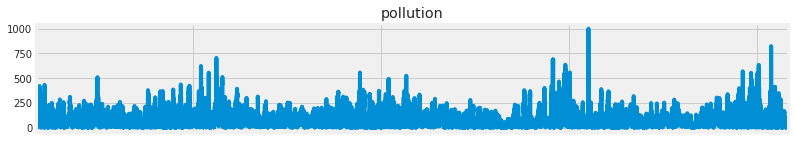

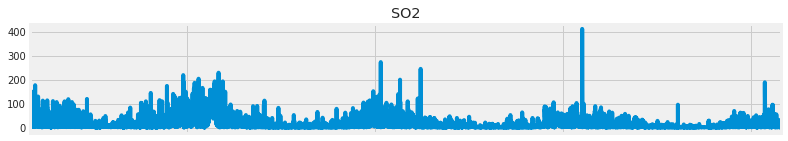

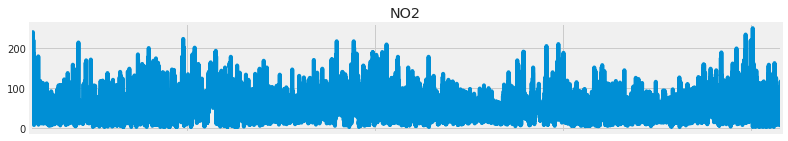

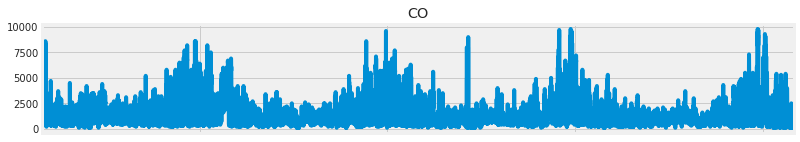

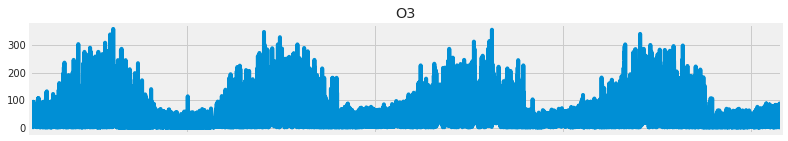

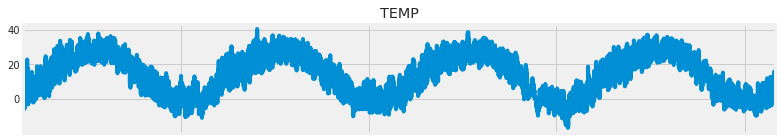

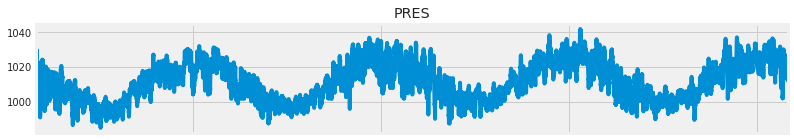

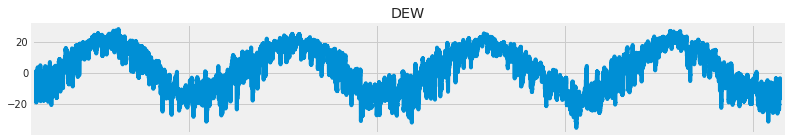

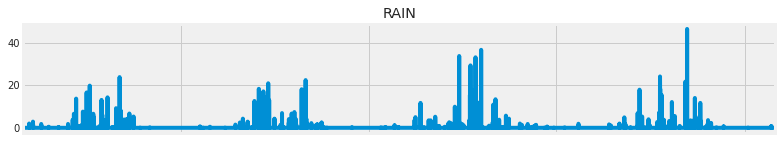

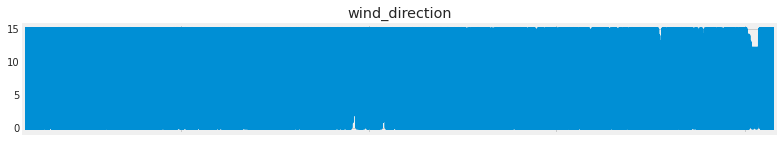

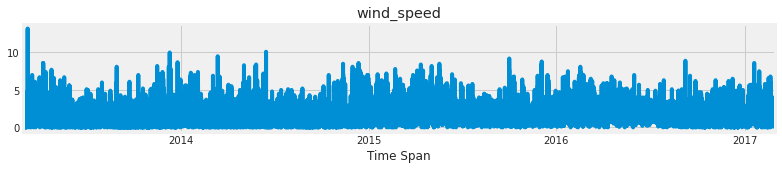

In [17]:
# get the columns with numerical entries
num_df = df.select_dtypes(include=[np.number])

# Get the numerical columns
num_cols = num_df.columns.tolist()

for i, col in enumerate(df[num_cols]):
    plt.figure(figsize=(12,2))
    df[col].plot()
    #plt.title("Distribution of " + col)
    plt.title(col, y=1, loc='center')
    if i == 10:
      plt.xlabel('Time Span')
    else:
      plt.xlabel(None)
      plt.tick_params(bottom=False,
                      labelbottom=False)

## Transform the data into a time series problem
Time series problems could be structured in various ways depending on what problem one is trying to solve. As earlier started, we are interested in predicting the amount of PM2.5 particles in the atmosphere. To achieve this, we will format the original dataset to a supervised learning dataset. 

The dataset is formatted using the "series_to_supervised" method from 

In [18]:
def series_to_supervised(data, columns, num_in=1, num_out=1, dropnan=True):
  """
    Converts a multivariate time series dataset into a supervised
    learning dataset format.

    args:
      data: a list or 2D numpy array of a sequence of observations
      columns: columns of the data
      num_in: number of lag observations set as features
      num_out: number of lag observations set as target variable
      dropnan: Boolean value to determine whether or not to drop rows
               NaN values.

    return:
      dataframe of the time series data formmatted for supervised
      learning
  """
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(num_in, 0, -1):
      cols.append(df.shift(i))
      names += [('%s(t-%d)' % (col, i)) for col in columns]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, num_out):
      cols.append(df.shift(-i))
      if i == 0:
          names += [('%s(t)' % (col)) for col in columns]
      else:
          names += [('%s(t+%d)' % (col, i)) for col in columns]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
      agg.dropna(inplace=True)
  return agg

In [19]:
# select the column names
columns = df.columns

# reformat dataset to supervised learning dataset
df_formatted = series_to_supervised(values, columns,1, 1)

# set the index as in the original dataset
# shifted by one hour
df_formatted.index = df.index[1:]

# display first 5 rows
df_formatted.head(2)

,pollution(t-1),SO2(t-1),NO2(t-1),CO(t-1),O3(t-1),TEMP(t-1),PRES(t-1),DEW(t-1),RAIN(t-1),wind_direction(t-1),wind_speed(t-1),pollution(t),SO2(t),NO2(t),CO(t),O3(t),TEMP(t),PRES(t),DEW(t),RAIN(t),wind_direction(t),wind_speed(t)
datetime,,,,,,,,,,,,,,,,,,,,,,
2013-03-01 01:00:00,9.0,6.0,17.0,200.0,62.0,0.3,1021.9,-19.0,0.0,14.0,2.0,11.0,7.0,14.0,200.0,66.0,-0.1,1022.4,-19.3,0.0,14.0,4.4
2013-03-01 02:00:00,11.0,7.0,14.0,200.0,66.0,-0.1,1022.4,-19.3,0.0,14.0,4.4,8.0,5.0,16.0,200.0,59.0,-0.6,1022.6,-19.7,0.0,14.0,4.7


The `series_to_supervised1` function shifts the dataset such that the dataset now contains columns with pollution data at the current hour (i.e. at time *t*) and pollution data at the previous hour (i.e. at time *t-1*). 

We will drop all other columns at time, *t*, and leave the pollution column at time, *t*. This will be the target variable (*y*), and the columns at time, *t-1*, will be the set of features (*X*).

This will formulate the problem as using previous air pollution values (past) to predict current PM2.5 values (future)..

In [20]:
# drop columns we don't want to predict
df_formatted.drop(df_formatted.columns[np.arange(12,22)], axis=1, inplace=True)

# display first 5 rows
df_formatted.head()

,pollution(t-1),SO2(t-1),NO2(t-1),CO(t-1),O3(t-1),TEMP(t-1),PRES(t-1),DEW(t-1),RAIN(t-1),wind_direction(t-1),wind_speed(t-1),pollution(t)
datetime,,,,,,,,,,,,
2013-03-01 01:00:00,9.0,6.0,17.0,200.0,62.0,0.3,1021.9,-19.0,0.0,14.0,2.0,11.0
2013-03-01 02:00:00,11.0,7.0,14.0,200.0,66.0,-0.1,1022.4,-19.3,0.0,14.0,4.4,8.0
2013-03-01 03:00:00,8.0,5.0,16.0,200.0,59.0,-0.6,1022.6,-19.7,0.0,14.0,4.7,8.0
2013-03-01 04:00:00,8.0,3.0,16.0,250.0,47.5,-0.7,1023.5,-20.9,0.0,7.0,2.6,8.0
2013-03-01 05:00:00,8.0,3.0,12.0,300.0,36.0,-0.9,1024.1,-21.7,0.0,14.0,2.5,10.0


To speed up the model training, we will ensure that all the variables are on the scale. To do this, we will use Python Scikit-learn estimator, `MinMaxScaler`, which scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

In [21]:
# Instantiate the estimator
scaler = MinMaxScaler(feature_range=(0,1))

# Fit to data, and return data in transformed form
scaled = scaler.fit_transform(values)

# reformat scaled dataset to supervised learning dataset
df_scaled = series_to_supervised(scaled, columns,1, 1)

# set the index as in the original dataset
# shifted by one hour
df_scaled.index = df.index[1:]

# drop columns we don't want to predict
df_scaled.drop(df_scaled.columns[np.arange(12,22)], axis=1, inplace=True)

# display first 5 rows
df_scaled.head()

,pollution(t-1),SO2(t-1),NO2(t-1),CO(t-1),O3(t-1),TEMP(t-1),PRES(t-1),DEW(t-1),RAIN(t-1),wind_direction(t-1),wind_speed(t-1),pollution(t)
datetime,,,,,,,,,,,,
2013-03-01 01:00:00,0.006024,0.013913,0.060241,0.010309,0.172689,0.297909,0.646749,0.255486,0.0,0.933333,0.151515,0.008032
2013-03-01 02:00:00,0.008032,0.016348,0.048193,0.010309,0.183869,0.290941,0.655536,0.250784,0.0,0.933333,0.333333,0.005020
2013-03-01 03:00:00,0.005020,0.011479,0.056225,0.010309,0.164304,0.282230,0.659051,0.244514,0.0,0.933333,0.356061,0.005020
2013-03-01 04:00:00,0.005020,0.006609,0.056225,0.015464,0.132162,0.280488,0.674868,0.225705,0.0,0.466667,0.196970,0.005020
2013-03-01 05:00:00,0.005020,0.006609,0.040161,0.020619,0.100020,0.277003,0.685413,0.213166,0.0,0.933333,0.189394,0.007028


# Split the data to training, validation and test sets

Time series datasets are usually ordered or sampled, and therefore cannot be randomly shuffled and split into the various sets for training, validation and test. So we will use the first 2 years of data for training the LSTM model, the next one year for in-training validation, and the last year for testing. The test set will act as data that the model has never been exposed to, therefore we will be prediciting the pollution for the last year.

Since the data was sampled hourly, there will be 24 rows of data recorded in a day. For year worth of observations, there will be 365*24 rows of observations.

In [22]:
# get the values of the scaled dataset
values = df_scaled.values

# number of rows for the first 2 years: Mar 2013 - Feb 2015
n_train = 365*24*2

# number of rows for the next year: 2015 - 2016
n_val = 365*24

# split the dataset
train = values[:n_train]
val = values[n_train:n_train+n_val]
test = values[n_train+n_val:]

# set previous data (t-1) as features and
# current data (at time t) as target
trainX, trainY = train[:,:-1], train[:,-1]
valX, valY = val[:,:-1], val[:,-1]
testX, testY = test[:,:-1], test[:,-1]

In [23]:
print(trainX.shape,trainY.shape,valX.shape, valY.shape, testX.shape,testY.shape)

(17520, 11) (17520,) (8760, 11) (8760,) (8783, 11) (8783,)


LSTM models requires in 3D data as input, but out training, validation and test sets are all 2-dimensional. So we will reshape the data to 3-dimensional, in the form of [totalRows, batch_size, num_features], 

where
- totalRows: dimension of the data
- batch_size: the number of observations passed to the model per training cycle
- num_features: the number of features in the dataset

In [24]:
# reshape the dataset
trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1]) 
valX = valX.reshape(valX.shape[0],1,valX.shape[1])
testX = testX.reshape(testX.shape[0],1,testX.shape[1])

print("Training: ",trainX.shape)
print("Validation: ",valX.shape)
print("Test: ",testX.shape)

Training:  (17520, 1, 11)
Validation:  (8760, 1, 11)
Test:  (8783, 1, 11)


# Build the model
Given the size of the training set (i.e. 17,520), it is likely to take very long to train the model. However, we can monitor the model as it is being trained to see if it improves per cycle. If it isn't improving, then we can stop the training early. We define a `patience` argument, which is simply the number of epochs or training cycles with no improvement after which training will be stopped.

In [25]:
def create_model(num_lstm_units=50, num_dropout=0.2):
  """
    Create an LSTM model
    args:
      num_lstm_units: number of units of the LSTM
      num_dropout: randomly sets a percentage of the 
                  input units to 0 at each step during 
                  training time, which helps prevent 
                  overfitting.
    return:
      LSTM model
  
  """
  # groups a linear stack of layers into a model
  model = Sequential()

  # add LSTM layer and dropout
  model.add(LSTM(num_lstm_units,
                 input_shape=(trainX.shape[1],trainX.shape[2]),
                 dropout=num_dropout))
  
  # add a Dense layer with unit (regression)
  model.add(Dense(1, activation='sigmoid'))

  # set optimisation method and metrics for model
  # performance monitoring
  model.compile(optimizer='adam', loss='mse')

  return model

# Initialize the model
lstm_model = create_model()

# display model summary
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                12400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 12,451
Trainable params: 12,451
Non-trainable params: 0
_________________________________________________________________


We notice the model has 12,451 parameters to train. 

In [26]:
# Fit the model of the training set
# train for 50 epochs
# pass a day's worth of observations to the model, i.e. batch size
lstm_history= lstm_model.fit(trainX,trainY,
                   validation_data=(valX,valY),
                   epochs=50,
                   batch_size=24,
                   verbose=2)

Epoch 1/50
730/730 - 4s - loss: 0.0195 - val_loss: 0.0047
Epoch 2/50
730/730 - 1s - loss: 0.0036 - val_loss: 0.0018
Epoch 3/50
730/730 - 1s - loss: 0.0023 - val_loss: 0.0016
Epoch 4/50
730/730 - 1s - loss: 0.0021 - val_loss: 0.0013
Epoch 5/50
730/730 - 1s - loss: 0.0021 - val_loss: 0.0013
Epoch 6/50
730/730 - 1s - loss: 0.0019 - val_loss: 0.0012
Epoch 7/50
730/730 - 1s - loss: 0.0019 - val_loss: 0.0010
Epoch 8/50
730/730 - 1s - loss: 0.0020 - val_loss: 0.0012
Epoch 9/50
730/730 - 1s - loss: 0.0018 - val_loss: 0.0012
Epoch 10/50
730/730 - 1s - loss: 0.0018 - val_loss: 0.0012
Epoch 11/50
730/730 - 1s - loss: 0.0018 - val_loss: 0.0015
Epoch 12/50
730/730 - 1s - loss: 0.0018 - val_loss: 0.0013
Epoch 13/50
730/730 - 1s - loss: 0.0018 - val_loss: 0.0013
Epoch 14/50
730/730 - 1s - loss: 0.0017 - val_loss: 0.0013
Epoch 15/50
730/730 - 1s - loss: 0.0017 - val_loss: 0.0014
Epoch 16/50
730/730 - 1s - loss: 0.0017 - val_loss: 0.0013
Epoch 17/50
730/730 - 1s - loss: 0.0016 - val_loss: 0.0013
Epoch 

## Plot the training and validation losses of the LSTM model

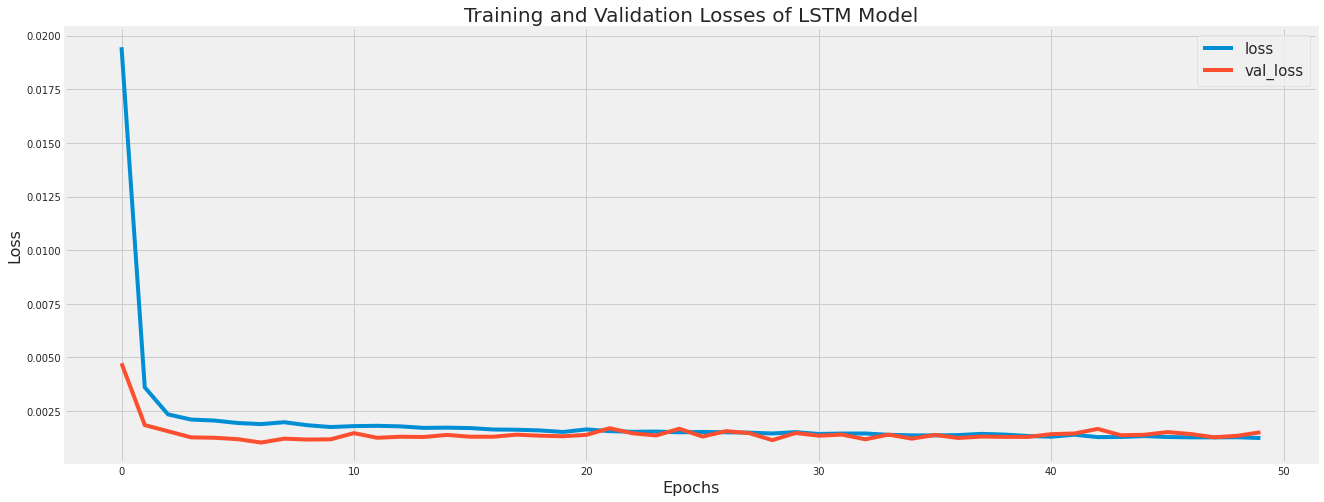

In [27]:
def plot_graphs(history, string, title=None):
    """
    Plots the training and validation loss at training time.
    
    args:
        history: holds the values of the training
                 time loss for the training and validation sets
       string: text representing either loss for the plotting step
    """
    plt.figure(figsize=(20,8))
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel(string.title(), fontsize=16)
    plt.title(title, fontsize=20)
    plt.legend([string, 'val_'+string], prop={'size': 15})
    plt.show()

lstm_title = "Training and Validation Losses of LSTM Model"
plot_graphs(lstm_history, "loss", lstm_title)

The plot shows that the models yields a fit on the training data and generalises very well on the validation. The validation loss is low, but slightly higher than training loss. This is the expected result, as this avoids overfitting on the training data.

## Predict future pollution from the test set
We will use the test set, which holds past values of the features (i.e. air pollution values at time *t-1*), to predict the future pollution values of PM2.5 (i.e. PM2.5 values at time *t*). The predicted PM2.5 values will be concatenated with the test set, but with the PM2.5 column at time *t-1* dropped.

In [28]:
def predict_pollution(model, test_set_features):
  # make a prediction
  pollution_arr = model.predict(test_set_features)

  # reshape the input features of the test set
  X_test = test_set_features.reshape((test_set_features.shape[0], 
                                      test_set_features.shape[2]))

  # concatenate the predicted PM2.5 values at time t, with the test set, 
  # but with the actual PM2.5 values at time t-1 dropped
  pollution = np.concatenate((pollution_arr, X_test[:, 1:]), axis=1)

  # invert scale the concatenated data for forecast
  predicted_pollution = scaler.inverse_transform(pollution)
  predicted_pollution_df = pd.DataFrame(predicted_pollution, columns=df.columns)
  
  return predicted_pollution_df

lstm_predicted = predict_pollution(lstm_model, testX)
lstm_predicted.head()

,pollution,SO2,NO2,CO,O3,TEMP,PRES,DEW,RAIN,wind_direction,wind_speed
0,14.664573,4.0,17.0,300.0,67.0,-2.3,1030.7,-19.7,0.0,4.0,2.0
1,16.324809,5.0,28.0,300.0,53.0,-3.3,1030.9,-19.7,0.0,2.0,1.4
2,16.346299,4.0,22.0,300.0,58.0,-4.8,1030.9,-18.3,0.0,1.0,0.9
3,15.782053,3.0,17.0,300.0,65.0,-5.3,1030.7,-18.4,0.0,0.0,0.9
4,22.359475,5.0,42.0,600.0,30.0,-6.3,1030.8,-16.6,0.0,0.0,1.2


Again we concatenate the actual future PM2.5 pollution values (i.e. PM2.5 values at time *t*), with the previous air poluution values from the test set, but with the previous PM2.5 pollution values dropped. This is to enable us compare predicted PM2.5 values with the actual PM2.5 values, and therefore be able to compute the root mean squared error of the predicted values.

In [29]:
def get_actual_pollution(test_set_target, test_set_features):
  # reshape the target variable of the test set
  testY = test_set_target.reshape((len(test_set_target), 1))

  # reshape the input features of the test set
  X_test = test_set_features.reshape((test_set_features.shape[0], 
                                      test_set_features.shape[2]))

  # concatenate the actual PM2.5 values at time t, with the test set, 
  # but with the actual PM2.5 values at time t-1 dropped
  actual = np.concatenate((testY, X_test[:, 1:]), axis=1)

  # invert scale the concatenated data for forecast
  actual = scaler.inverse_transform(actual)
  actual = pd.DataFrame(actual, columns=df.columns)
  
  return actual

actual = get_actual_pollution(testY, testX)
actual.head()

,pollution,SO2,NO2,CO,O3,TEMP,PRES,DEW,RAIN,wind_direction,wind_speed
0,5.0,4.0,17.0,300.0,67.0,-2.3,1030.7,-19.7,0.0,4.0,2.0
1,8.0,5.0,28.0,300.0,53.0,-3.3,1030.9,-19.7,0.0,2.0,1.4
2,10.0,4.0,22.0,300.0,58.0,-4.8,1030.9,-18.3,0.0,1.0,0.9
3,13.0,3.0,17.0,300.0,65.0,-5.3,1030.7,-18.4,0.0,0.0,0.9
4,13.0,5.0,42.0,600.0,30.0,-6.3,1030.8,-16.6,0.0,0.0,1.2


In [30]:
# calculate RMSE
lstm_rmse = np.sqrt(mean_squared_error(actual, lstm_predicted))
print('LSTM RMSE: %.3f' % lstm_rmse)

LSTM RMSE: 12.130


### Create dataframe of predicted and actual prediction values

In [31]:
# get actual and predicted PM2.5 values
actual_series = actual.pollution
lstm_predicted_series = lstm_predicted.pollution

# concatenate the predicted and actual PM2.5 values
lstm_pollution_PM25 = pd.concat([actual_series ,lstm_predicted_series],axis=1)
lstm_pollution_PM25.columns = ['Actual', 'Predicted']

# the index shifted by one
lstm_pollution_PM25.index = df_formatted.iloc[n_train+n_val:].index
lstm_pollution_PM25['diff'] = lstm_pollution_PM25['Actual'] - lstm_pollution_PM25['Predicted']
lstm_pollution_PM25.head()

,Actual,Predicted,diff
datetime,,,
2016-02-29 01:00:00,5.0,14.664573,-9.664573
2016-02-29 02:00:00,8.0,16.324809,-8.324809
2016-02-29 03:00:00,10.0,16.346299,-6.346299
2016-02-29 04:00:00,13.0,15.782053,-2.782053
2016-02-29 05:00:00,13.0,22.359475,-9.359475


### Define function to print the predictions

In [32]:
def print_future_pollution(past_train_set, pollution_df, num_rows=None, 
                           title_fontsize=None, date=None, title=None, 
                           figure=True):
  if figure:
    plt.figure(figsize=(20,8))

  # display last 100 hours of training data
  plt.plot(past_train_set['pollution(t)'][-100:], label='training')

  # display first few hours into the future
  plt.plot(pollution_df.Actual[:num_rows], label='test')

  # display prediction of first few hours into the future
  plt.plot(pollution_df.Predicted[:num_rows], label='predicted')

  # vertical line indicating end of training set and beginning of test
  # and predicted set
  plt.axvline(pd.to_datetime(date), color='k', linestyle='--', lw=3)
  plt.title(title, fontsize=title_fontsize)
  plt.xlabel("Timespan", fontsize=16)
  plt.ylabel("PM2.5", fontsize=16)
  plt.legend();

## Prediction of 200 hours pollution into the future

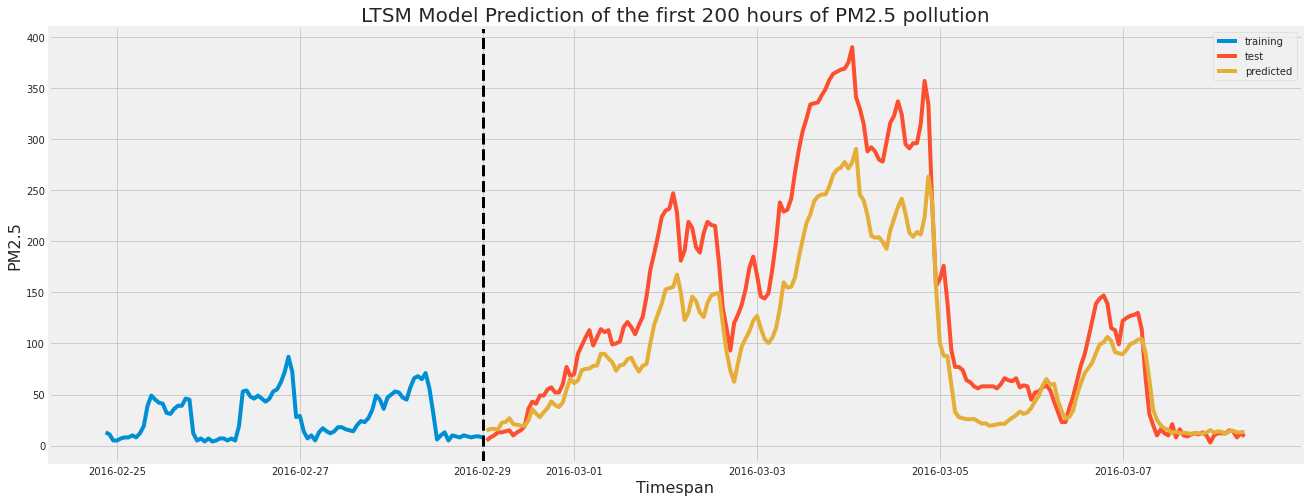

In [33]:
# Number of rows in the training data
num_train = n_train + n_val
past_train_set = df_formatted[:num_train]

##======== define the parameters for the plot function =====
# date of the last training records
date = str(past_train_set.index[-1]).split()[0]

# number of hours into the future to predict and compare with the test set
num_rows = 200   

# define the title for the plot
title = "LTSM Model Prediction of the first 200 hours of PM2.5 pollution"

# plot the prediction for the first 200 hours of pollution into the future
print_future_pollution(past_train_set, lstm_pollution_PM25, num_rows, 20, date, title)

## Prediction of 500 hours pollution into the future

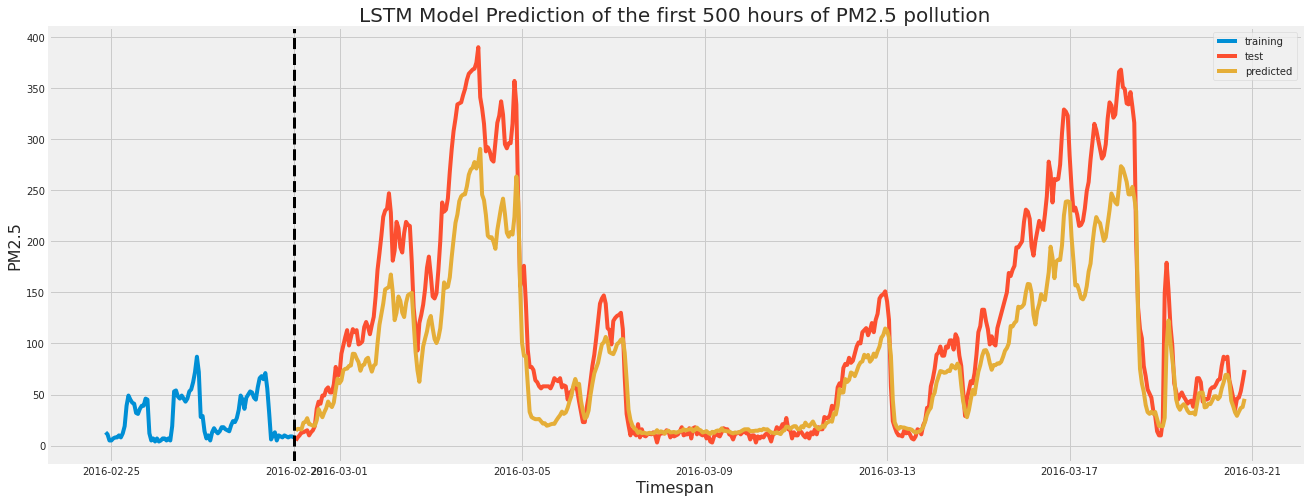

In [34]:
##======== define the parameters for the plot function =====
# number of hours into the future to predict and compare with the test set
num_rows = 500   

# define the title for the plot
title = "LSTM Model Prediction of the first 500 hours of PM2.5 pollution"

# plot the prediction for the first 500 hours of pollution into the future
print_future_pollution(past_train_set, lstm_pollution_PM25, num_rows, 20, date, title)

## Prediction of the last 1000 hours pollution in the test set

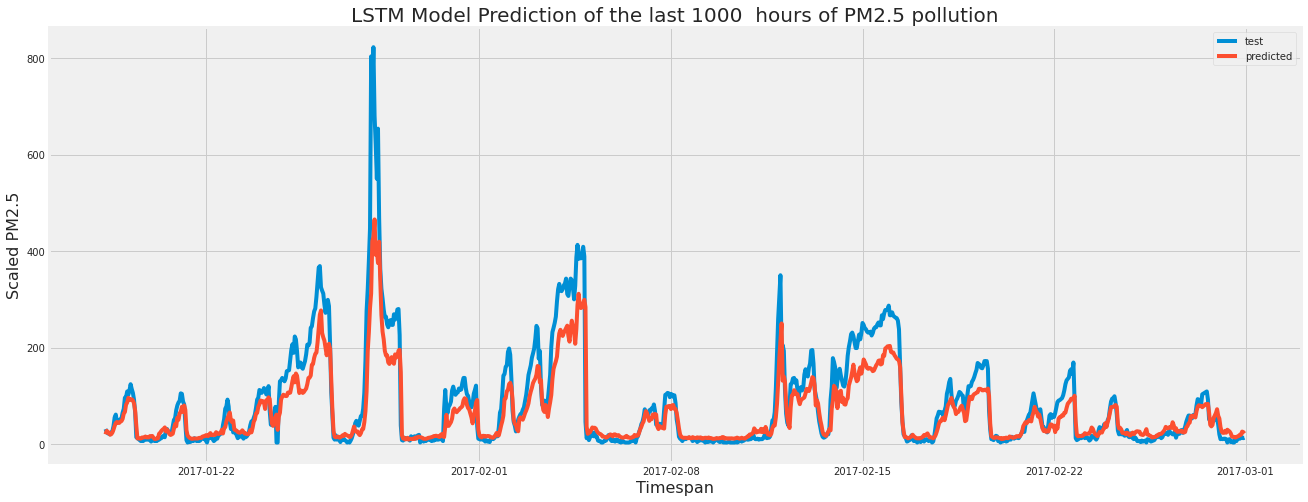

In [35]:
plt.figure(figsize=(20,8))
plt.plot(lstm_pollution_PM25.Actual[-1000:], label='test')
plt.plot(lstm_pollution_PM25.Predicted[-1000:], label='predicted')
plt.title("LSTM Model Prediction of the last 1000  hours of PM2.5 pollution", fontsize=20)
plt.xlabel("Timespan", fontsize=16)
plt.ylabel("Scaled PM2.5", fontsize=16)
plt.legend();

# Model 2: CNN-LSTM Model

In [36]:
def create_model(filter=32, kernel_size=3, strides=1, num_lstm_units=50, num_dropout=0.2):
  """
    Creates a CNN-LSTM model
    args:
      filter: 
      kernel_size: 
      strides: 
      num_lstm_units: number of units of the LSTM
      num_dropout: randomly sets a percentage of the 
                  input units to 0 at each step during 
                  training time, which helps prevent 
                  overfitting.
    return:
      LSTM model
  
  """
  # groups a linear stack of layers into a model
  model = Sequential()

  # Defines a Convolutional layer
  model.add(Conv1D(filters=filter, 
                   kernel_size=kernel_size, 
                   strides=strides, 
                   padding='causal',
                   activation='relu',
                   input_shape=(trainX.shape[1],trainX.shape[2])))

  # add LSTM layer and dropout
  model.add(LSTM(num_lstm_units,
                 input_shape=(trainX.shape[1],trainX.shape[2]),
                 dropout=num_dropout))
  
  # add a Dense layer with unit (regression)
  model.add(Dense(1, activation='sigmoid'))

  # set optimisation method and metrics for model
  # performance monitoring
  model.compile(optimizer='adam', loss='mse')

  return model

# Initialize the CNN-LSTM model
cnn_lstm_model = create_model()

# display model summary
cnn_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 32)             1088      
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 17,739
Trainable params: 17,739
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Fit the model of the training set
# train for 50 epochs
# pass a day's worth of observations to the model, i.e. batch size
cnn_lstm_history = cnn_lstm_model.fit(trainX,trainY,
                   validation_data=(valX,valY),
                   epochs=50,
                   batch_size=24,
                   verbose=2)

Epoch 1/50
730/730 - 4s - loss: 0.0121 - val_loss: 0.0015
Epoch 2/50
730/730 - 2s - loss: 0.0015 - val_loss: 8.7702e-04
Epoch 3/50
730/730 - 1s - loss: 9.3841e-04 - val_loss: 7.9943e-04
Epoch 4/50
730/730 - 2s - loss: 7.5812e-04 - val_loss: 6.8879e-04
Epoch 5/50
730/730 - 1s - loss: 6.8446e-04 - val_loss: 6.5554e-04
Epoch 6/50
730/730 - 2s - loss: 6.6679e-04 - val_loss: 6.1480e-04
Epoch 7/50
730/730 - 1s - loss: 6.3559e-04 - val_loss: 5.9871e-04
Epoch 8/50
730/730 - 2s - loss: 6.0214e-04 - val_loss: 5.5047e-04
Epoch 9/50
730/730 - 1s - loss: 5.7332e-04 - val_loss: 5.0708e-04
Epoch 10/50
730/730 - 2s - loss: 5.7508e-04 - val_loss: 5.0612e-04
Epoch 11/50
730/730 - 1s - loss: 5.6859e-04 - val_loss: 5.3923e-04
Epoch 12/50
730/730 - 2s - loss: 5.5560e-04 - val_loss: 5.1838e-04
Epoch 13/50
730/730 - 1s - loss: 5.6113e-04 - val_loss: 5.9652e-04
Epoch 14/50
730/730 - 2s - loss: 5.4750e-04 - val_loss: 4.9214e-04
Epoch 15/50
730/730 - 1s - loss: 5.2611e-04 - val_loss: 4.8210e-04
Epoch 16/50
730/

## Plot the training and validation losses of the CNN-LSTM model

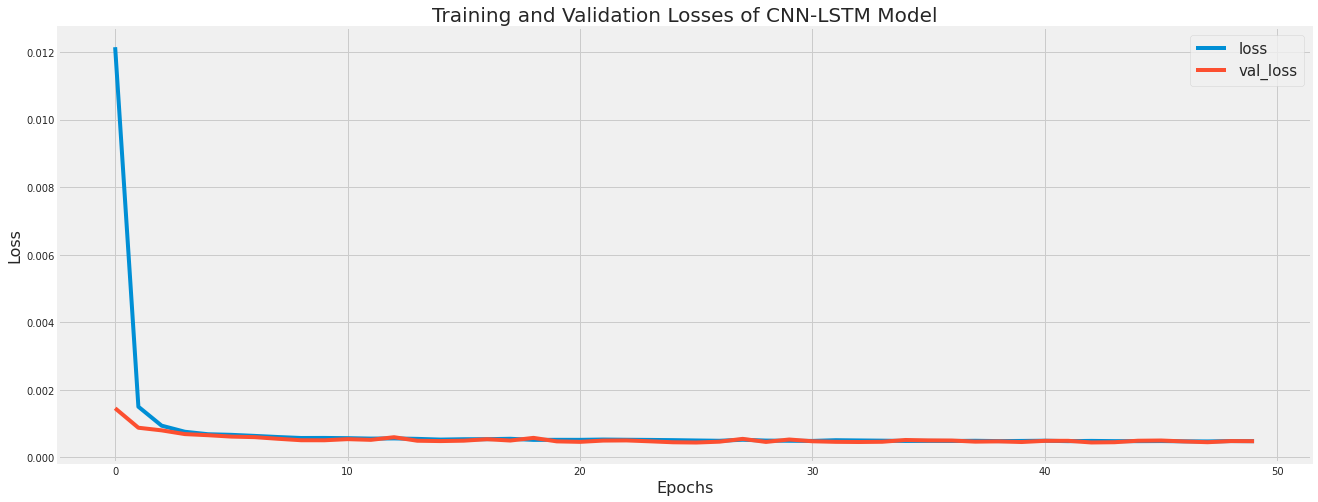

In [38]:
cnn_lstm_title = "Training and Validation Losses of CNN-LSTM Model"
plot_graphs(cnn_lstm_history, "loss", cnn_lstm_title)

## Predict future pollution from the test set

In [39]:
cnn_lstm_predicted = predict_pollution(cnn_lstm_model, testX)
cnn_lstm_predicted.head()

,pollution,SO2,NO2,CO,O3,TEMP,PRES,DEW,RAIN,wind_direction,wind_speed
0,11.043114,4.0,17.0,300.0,67.0,-2.3,1030.7,-19.7,0.0,4.0,2.0
1,10.510629,5.0,28.0,300.0,53.0,-3.3,1030.9,-19.7,0.0,2.0,1.4
2,11.278531,4.0,22.0,300.0,58.0,-4.8,1030.9,-18.3,0.0,1.0,0.9
3,11.703326,3.0,17.0,300.0,65.0,-5.3,1030.7,-18.4,0.0,0.0,0.9
4,13.969009,5.0,42.0,600.0,30.0,-6.3,1030.8,-16.6,0.0,0.0,1.2


In [40]:
# calculate RMSE
cnn_lstm_rmse = np.sqrt(mean_squared_error(actual, cnn_lstm_predicted))
print('CNN-LSTM RMSE: %.3f' % cnn_lstm_rmse)

CNN-LSTM RMSE: 6.782


### Create dataframe of predicted and actual prediction values

In [41]:
# get actual and predicted PM2.5 values
actual_series = actual.pollution
cnn_lstm_predicted_series = cnn_lstm_predicted.pollution

# concatenate the predicted and actual PM2.5 values
cnn_lstm_pollution_PM25 = pd.concat([actual_series ,cnn_lstm_predicted_series],axis=1)
cnn_lstm_pollution_PM25.columns = ['Actual', 'Predicted']

# the index shifted by one
cnn_lstm_pollution_PM25.index = df_formatted.iloc[n_train+n_val:].index
cnn_lstm_pollution_PM25['diff'] = cnn_lstm_pollution_PM25['Actual'] - cnn_lstm_pollution_PM25['Predicted']
cnn_lstm_pollution_PM25.head()

,Actual,Predicted,diff
datetime,,,
2016-02-29 01:00:00,5.0,11.043114,-6.043114
2016-02-29 02:00:00,8.0,10.510629,-2.510629
2016-02-29 03:00:00,10.0,11.278531,-1.278531
2016-02-29 04:00:00,13.0,11.703326,1.296674
2016-02-29 05:00:00,13.0,13.969009,-0.969009


## Prediction of 200 hours pollution into the future

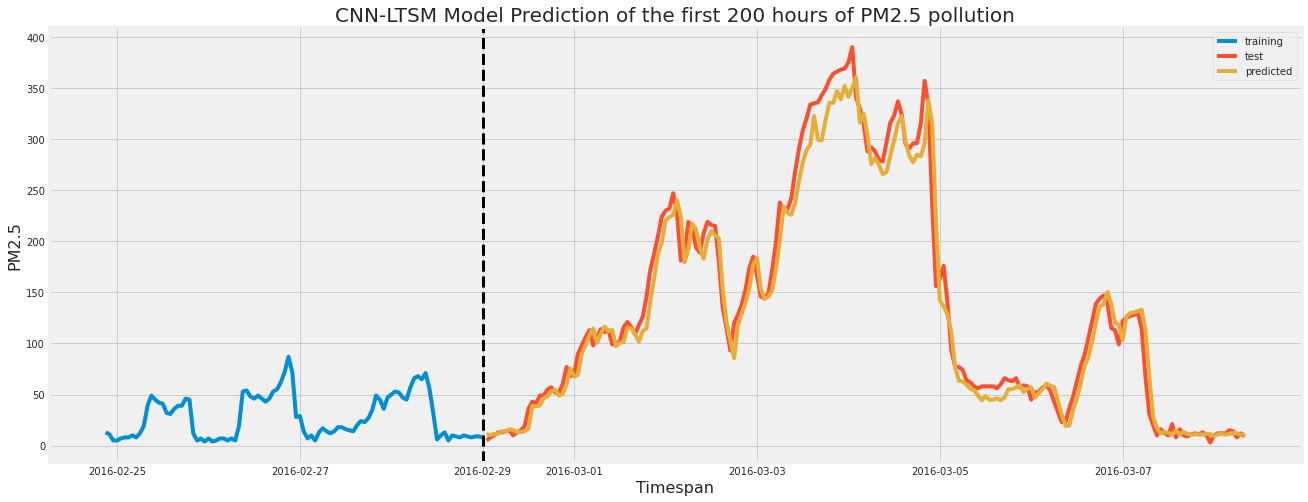

In [42]:
# Number of rows in the training data
num_train = n_train + n_val
past_train_set = df_formatted[:num_train]

##======== define the parameters for the plot function =====
# date of the last training records
date = str(past_train_set.index[-1]).split()[0]

# number of hours into the future to predict and compare with the test set
num_rows = 200   

# define the title for the plot
title = "CNN-LTSM Model Prediction of the first 200 hours of PM2.5 pollution"

# plot the prediction for the first 200 hours of pollution into the future
print_future_pollution(past_train_set, cnn_lstm_pollution_PM25, num_rows, 20, date, title)

## Prediction of 500 hours pollution into the future

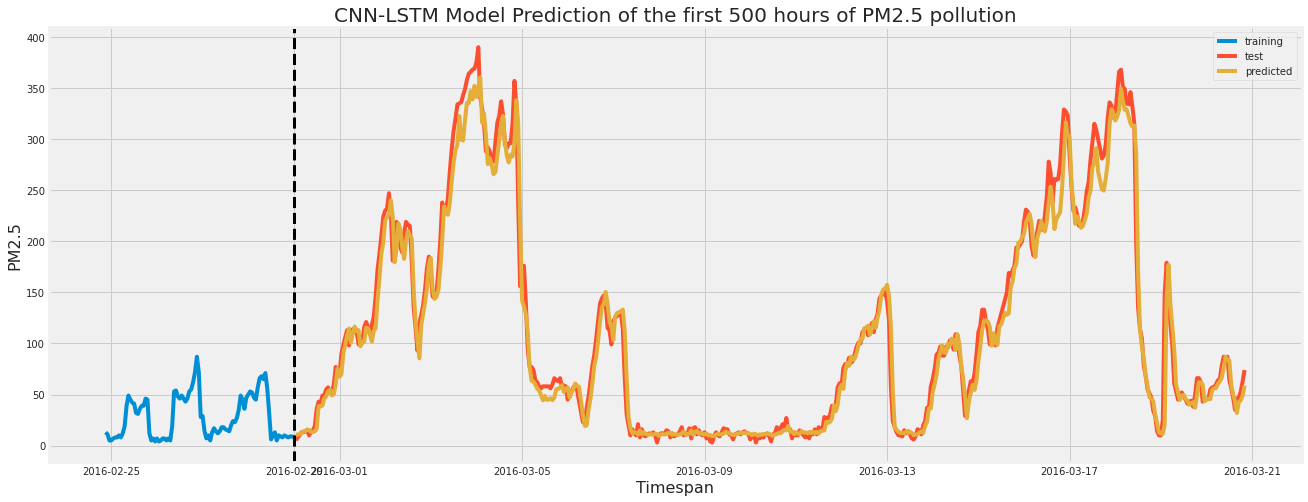

In [43]:
##======== define the parameters for the plot function =====
# number of hours into the future to predict and compare with the test set
num_rows = 500   

# define the title for the plot
title = "CNN-LSTM Model Prediction of the first 500 hours of PM2.5 pollution"

# plot the prediction for the first 500 hours of pollution into the future
print_future_pollution(past_train_set, cnn_lstm_pollution_PM25, num_rows, 20, date, title)

## Prediction of the last 1000 hours pollution in the test set

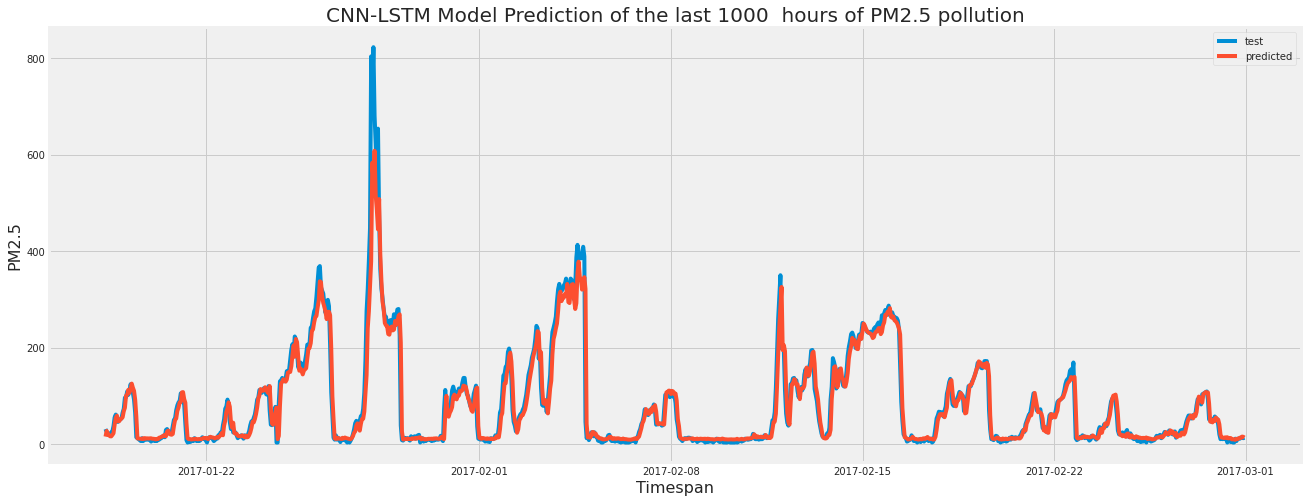

In [44]:
plt.figure(figsize=(20,8))
plt.plot(cnn_lstm_pollution_PM25.Actual[-1000:], label='test')
plt.plot(cnn_lstm_pollution_PM25.Predicted[-1000:], label='predicted')
plt.title("CNN-LSTM Model Prediction of the last 1000  hours of PM2.5 pollution", fontsize=20)
plt.xlabel("Timespan", fontsize=16)
plt.ylabel("PM2.5", fontsize=16)
plt.legend();

## Visualize the prediction errors of both models

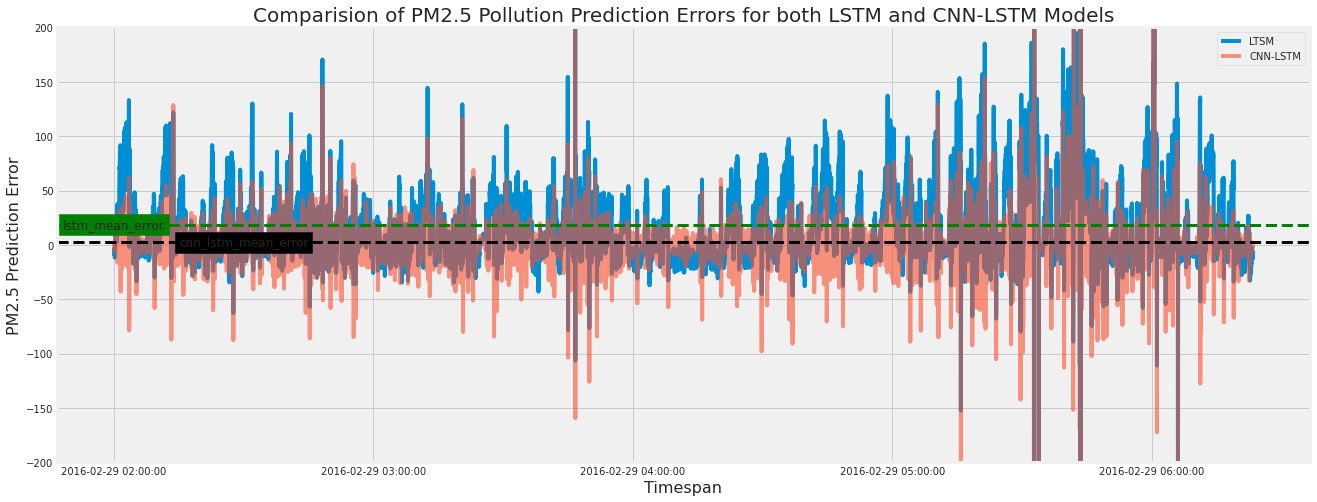

In [45]:
# Get the prediction errors of both models
lstm_diff = lstm_pollution_PM25['diff'].values
cnn_lstm_diff = cnn_lstm_pollution_PM25['diff'].values

# get the mean of the prediction errors of both models
lstm_mean = np.mean(lstm_diff)
cnn_lstm_mean = np.mean(cnn_lstm_diff)

#plt.figure(figsize=(20,8))
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(lstm_diff, label='LTSM')
ax.plot(cnn_lstm_diff, label='CNN-LSTM', alpha=0.6)
plt.title("Comparision of PM2.5 Pollution Prediction Errors for both LSTM and CNN-LSTM Models", fontsize=20)
plt.xlabel("Timespan", fontsize=16)
plt.ylabel("PM2.5 Prediction Error", fontsize=16)
ax.set_xticklabels(cnn_lstm_pollution_PM25.index)

# plot the mean of the LSTM prediction errors
plt.axhline(lstm_mean, color='g', linestyle='--', lw=3)
plt.text(0.5, lstm_mean, 'lstm_mean_error', fontsize=12, va='center', ha='center', backgroundcolor='g')

# plot the mean of the CNN-LSTM prediction errors
plt.axhline(cnn_lstm_mean, color='k', linestyle='--', lw=3)
plt.text(1000, cnn_lstm_mean, 'cnn_lstm_mean_error', fontsize=12, va='center', ha='center', backgroundcolor='k')

plt.ylim(-200, 200)
plt.legend();

A positive error between the actual and predicted pollution values means the model predicted a lower value than the actual value. Looking at the plot of the prediction errors for both models, we observe that the mean of the CNN-LSTM model predictions is closer to zero compared to the mean of the LSTM model. 

The CNN-LSTM model has an RMSE value of 6.75 compared to 11.68 of the LSTM model. This clearly shows a significant improvement by adding a convolutional layer to the LTSTM architecture.

# SUMMARY
## Compare the training and validation losses

In [46]:
def compare_losses(history, string, idx, title=None):
  """
  Compares the training and validation loss at training time.
  
  args:
      history: holds the values of the training
                time loss for the training and validation sets
      string: text representing either loss for the plotting step
      idx: index value for plot position and title selection
      title: title for each plot
  """
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.legend([string, 'val_' + string], prop={'size': 10})
  plt.xlabel("Epochs", fontsize=16)
  # display y-axis label only on first plot
  if idx == 0:
    plt.ylabel(string.title(), fontsize=16)
  plt.title(title, fontsize=18)

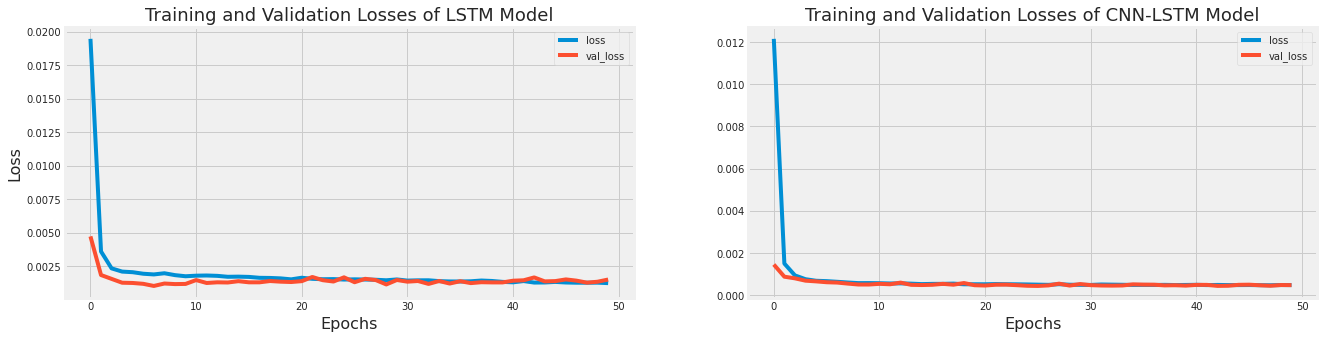

In [47]:
fig = plt.figure(figsize=(20,5))
title = ["Training and Validation Losses of LSTM Model", "Training and Validation Losses of CNN-LSTM Model"]

# loop through the training history of both models
for idx, history in enumerate([lstm_history, cnn_lstm_history]):
  # create subplots
  plt.subplot(1, 2, idx+1)
  compare_losses(history, 'loss', idx, title[idx])

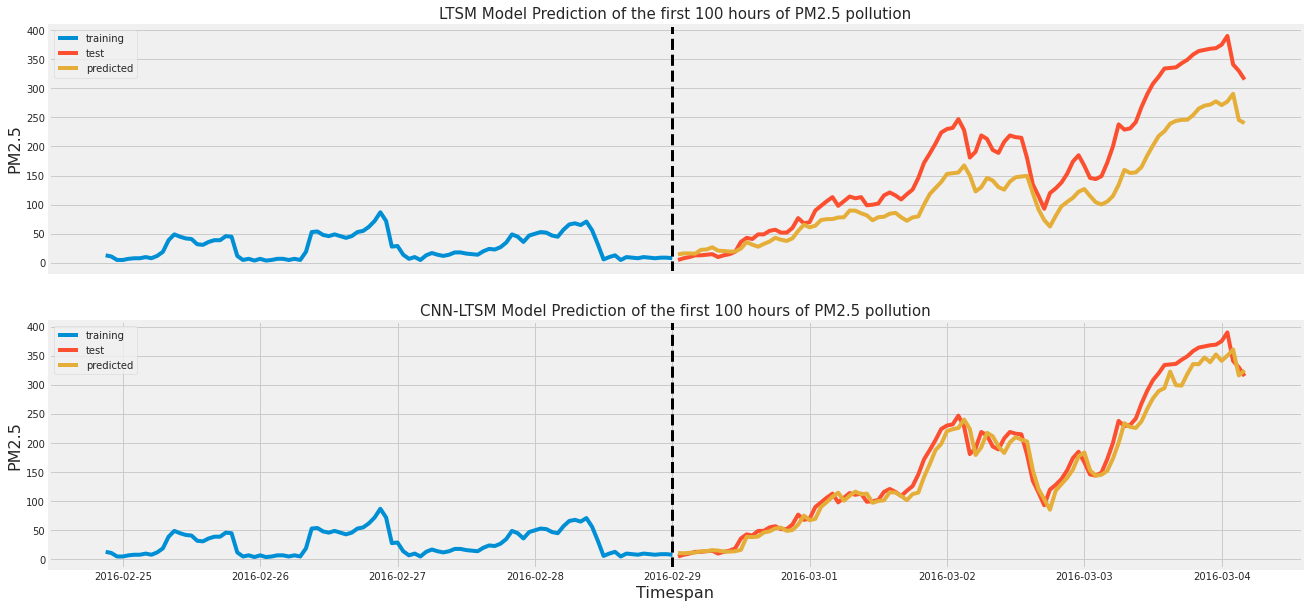

In [48]:
fig = plt.figure(figsize=(20,10))
num_rows = 100   
# define the title for the plot
title = ["LTSM Model Prediction of the first 100 hours of PM2.5 pollution",
         "CNN-LTSM Model Prediction of the first 100 hours of PM2.5 pollution"]

# select the prediction dataframe for both models
pollution_PM25 = [lstm_pollution_PM25, cnn_lstm_pollution_PM25]

for idx in range(2):
  plt.subplot(2, 1, idx+1)
  print_future_pollution(past_train_set, pollution_PM25[idx], num_rows, 15, date, title[idx], False)
  if idx == 0:
    plt.xticks([], [])
    plt.xlabel(None)

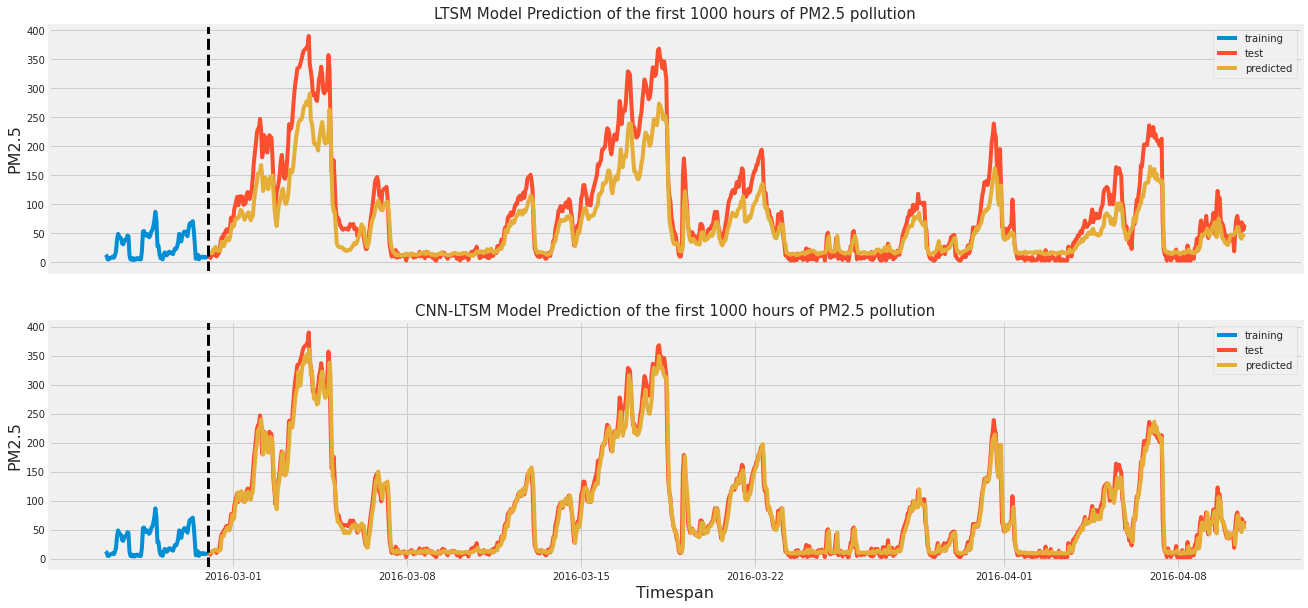

In [49]:
fig = plt.figure(figsize=(20,10))
num_rows = 1000   
# define the title for the plot
title = ["LTSM Model Prediction of the first 1000 hours of PM2.5 pollution",
         "CNN-LTSM Model Prediction of the first 1000 hours of PM2.5 pollution"]

for idx in range(2):
  plt.subplot(2, 1, idx+1)
  print_future_pollution(past_train_set, pollution_PM25[idx], num_rows, 15, date, title[idx], False)
  if idx == 0:
    plt.xticks([], [])
    plt.xlabel(None)